# NEUR182: XGBoost Tuning Example

### Try Predicting Lesion Category using Neuroimaging Data



In [1]:
import numpy as np
import matplotlib as mpl
import scipy as sp
import os
import sys

# Get ready to import the .mat file with the EEG data features
DataDir = '/Users/casruedy/Downloads/NEUR182/Code/Assignments/Final_Assignment'
DataFileName = 'PFC_EEG_FeatData.mat'
FullDataFileName = os.path.join(DataDir,DataFileName)
import scipy.io
# Import the data
FeatDataDict = scipy.io.loadmat(FullDataFileName)
print('The variable type of the imported data is a dictionary: ' + str(type(FeatDataDict)))
# Convert to numpy array
temp1 = FeatDataDict.items()
temp2 = list(temp1)
temp3 = np.array(temp2,dtype='object')
temp4 = temp3[3]
FeatData = temp4[1]
print('The variable type of the final form of our EEG Data is a numpy array: ' + str(type(FeatData)))
# Shape
print('Shape of the Data Matrix is: ' + str(FeatData.shape))
print('It has ' + str(FeatData.shape[0]) + ' participants (i.e., cases, observations, rows).')
print('It has ' + str(FeatData.shape[1]) + ' features (i.e., predictor variables, columns).')
# Data Format: Pretrial Data
# 20 participants (1-10 are Control, 11-20 are PFC)
# Column 1 is PptID
# Column 2 is Group
# Column 3 is Age
# Columns 4-22 are time bins 0 sec to 0.5 sec
# Columns 23-29 are frequency bins in Hz. Delta, Theta, Alpha, Low Beta, High Beta, Low Gamma.
# Columns 30 to 7326 are the signals for each of 64 electrodes: 6 x 19 x 64, for a total of 7296 EEG features

print('Group Id: ' + str(FeatData[:,1]))
print('Age: ' + str(FeatData[:,2]))

The variable type of the imported data is a dictionary: <class 'dict'>
The variable type of the final form of our EEG Data is a numpy array: <class 'numpy.ndarray'>
Shape of the Data Matrix is: (20, 7326)
It has 20 participants (i.e., cases, observations, rows).
It has 7326 features (i.e., predictor variables, columns).
Group Id: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Age: [20. 19. 21. 21. 19. 48. 45. 62. 70. 59. 48. 54. 46. 34. 64. 57. 71. 22.
 20. 41.]


## Organize the Data into OV and PVs

In [2]:
OV = FeatData[:,1] # Group of the participants
print('Shape of OV is ' + str(OV.shape))
print('Group = ' + str(OV))

Shape of OV is (20,)
Group = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Our PVs are the frequency-domain, spectrographic features. We have 6 frequency bands x 19 time bins for each electrode, and 64 total electrodes in all.

In [3]:
print('Number of features = ' + str(6 * 19 * 64))

PVs = FeatData[:,30:]
print('Shape of PVs is ' + str(PVs.shape))

Number of features = 7296
Shape of PVs is (20, 7296)


### XGBoost Hyperparameters

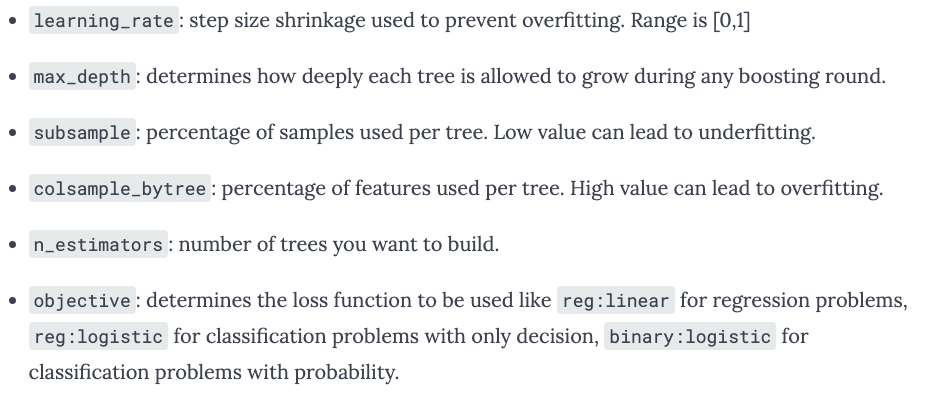

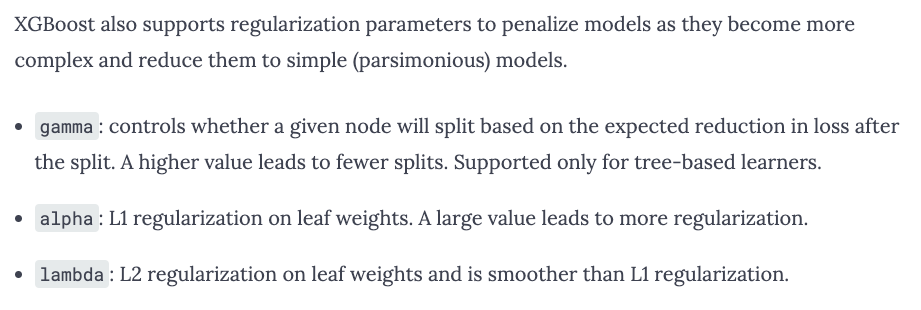

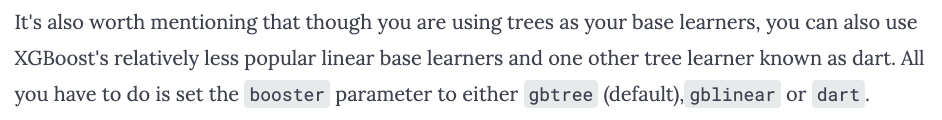

In [4]:
# Use XGBoost algorithm
import xgboost as xgb
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
from copy import deepcopy
import time
import warnings


# NonTesting and Testing Indices
# Make sure to STRATIFY according to the class proportions in our OV
PVsTrain, PVsTest, OVTrain, OVTest = model_selection.train_test_split(PVs,OV,
                                                                      test_size = 0.4,
                                                                      random_state = 100,
                                                                      stratify = OV)
print(OVTrain)
print(OVTest)

xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(PVsTrain,OVTrain)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(PVsTrain, OVTrain)

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(PVsTrain)
test_predictions = clf0.predict(PVsTest)

#confusion matrices
cfm_train = confusion_matrix(OVTrain, train_predictions)
cfm_test = confusion_matrix(OVTest, test_predictions)

#accuracy scores
accs_train = roc_auc_score(OVTrain, train_predictions)
accs_test = roc_auc_score(OVTest, test_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(OVTrain, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(OVTrain, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(OVTest, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(OVTest, test_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(OVTest, clf0.predict_proba(PVsTest)[:,1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
#dictionary for collecting results
results_dict = {}
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                         'best_params': bp}
print(bp)
print(accs_test)

[1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
[0. 0. 0. 1. 1. 0. 1. 1.]
Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eval_metric': 'auc', 'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'tree_method': 'hist', 'use_label_encoder': False, 'verbosity': 1}
0.75


In [6]:
# Now tune using GridSearchCV
# See: https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d

#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params,
                       scoring='roc_auc',
                       return_train_score=True,
                       verbose=1, cv=3, n_jobs = 3)
    clf.fit(PVsTrain, OVTrain)
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(PVsTrain)
    test_predictions = clf.predict(PVsTest)
    
    #confusion matrices
    cfm_train = confusion_matrix(OVTrain, train_predictions)
    cfm_test = confusion_matrix(OVTest, test_predictions)
    
    #accuracy scores
    accs_train = roc_auc_score(OVTrain, train_predictions)
    accs_test = roc_auc_score(OVTest, test_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(OVTrain, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(OVTrain, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(OVTest, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(OVTest, test_predictions, pos_label=0)

    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(OVTest, clf.predict_proba(PVsTest)[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  'test roc auc score': test_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 13.014441967010498 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits
iteration #2 finished in: 13.953642845153809 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits
iteration #3 finished in: 10.9664888381958 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits
iteration #4 finished in: 7.418932914733887 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #5 finished in: 7.646673202514648 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #6 finished in: 8.501550197601318 seconds


61.50319814682007
XGBClassifier(eval_metric='auc', gamma=6.4, grow_policy='lossguide',
              learning_rate=0.01, max_depth=5, n_estimators=50, reg_lambda=0.4,
              tree_method='hist', use_label_encoder=False)


/Users/mspezio/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.75
0.75


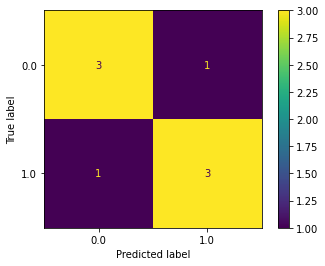

In [7]:
print(gcvt)
print(clf.best_estimator_)

test_predictions = clf.best_estimator_.predict(PVsTest)
metrics.plot_confusion_matrix(clf.best_estimator_,PVsTest,OVTest)
f1s_test_p1 = f1_score(OVTest, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(OVTest, test_predictions, pos_label=0)
print(f1s_test_p0)
print(f1s_test_p1)